# Clumps

Calculates enrichments in clumped isotopologues w.r.t. a stochastic distribution using the following formula (e.g. for $^{15}$N$^{16}$O $_{2}$$ ^{18}$O):

### $\Delta_{1518,sample}=\frac{\delta_{1518}+1}{f(\delta_{15}+1)(\delta_{18}+1)}\times (\Delta_{1518,reference}+1)-1$

Where the reference, UGSG35, defines the zero of the $\Delta$ scale and $f$ is a factor accounting for the isotopologue

1. Loads both M0 and noM0 data for the same samples
2. Calculates and plots their $\Delta$ values

### Import packages, user inputs

In [247]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# Inputs:
# paths = {'M0':'240222_std_test_1_M0/external_deltas_summary_2024-02-22.csv',
#          'noM0':'240222_std_test_1_noM0/external_deltas_summary_2024-02-22.csv'}
paths = {'M0':'240208_CdD_202-215_M0/calibrated_deltas_2024-02-28.csv',
         'noM0':'240212_CdD_202-215_noM0/calibrated_deltas_2024-02-28.csv'}

## 1. Load data
- Take $\delta^{15}N$, $\delta^{17}O$ and $\delta^{18}O$ from M0 experiment
- Take $\delta^{15}N^{18}O$, $\delta^{17}O^{18}O$ and $\delta^{18}O^{18}O$ from no-M0 experiment

In [254]:
data = paths.copy()
# load both experiment results
for key in data.keys():
    data[key] = pd.read_csv(paths[key])
    data[key].index=data[key]['sample_name']
    data[key].drop('sample_name',axis=1,inplace=True)  
    
# merge both experiment results
data_compiled = pd.merge(data['M0'],data['noM0'],
                         left_index=True, right_index=True, how='inner', suffixes=['','_noM0'])

data_compiled.dropna(axis=1,inplace=True)

data_compiled.head(10)

,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O,mean_d17O_noM0,mean_d18O_noM0,mean_d15N18O,err_d17O_noM0,err_d18O_noM0,err_d15N18O
sample_name,,,,,,,,,,,,
CDD-202,-0.002269,0.061610,0.070685,0.000605,0.001286,0.000450,0.061540,0.069678,0.070110,0.001226,0.000742,0.006876
CDD-203,-0.002601,0.053593,0.061409,0.000700,0.001170,0.000539,0.052430,0.060415,0.068040,0.000793,0.000426,0.005466
CDD-204,-0.002256,0.050336,0.058649,0.000630,0.001533,0.000400,0.050555,0.056581,0.073192,0.001341,0.000722,0.007594
CDD-205,-0.002047,0.058115,0.066332,0.000540,0.001505,0.000515,0.058463,0.065640,0.063569,0.000844,0.000434,0.005632
CDD-206,0.000552,0.063854,0.072704,0.000513,0.001106,0.000473,0.065565,0.073149,0.073383,0.001010,0.000551,0.005102
CDD-207,-0.003002,0.061652,0.069856,0.000832,0.001167,0.000505,0.062936,0.069673,0.074193,0.000880,0.000534,0.005570
CDD-208,-0.003110,0.061368,0.070856,0.000728,0.001067,0.000547,0.063151,0.069873,0.064787,0.000964,0.000617,0.006122


## 2. Calcualte nitrate clumped $\Delta$ values

Uses the formula: 

### $\Delta_{AB_{sample - USGS35}}=\frac{\delta_{AB}+1}{(\delta_{A}+1)(f\delta_{B}+1)} -1$

With calibrated sample deltas. Sample clumped deltas are calibrated assuming dried USGS35 has a stochastic composition.

`dict` contains `[ f , isotope A, isotope B ]` for each doubly-substituted isotopologue  
where `f` is multiplied by the simple delta values to calculate the stochastic compositions.  

$f=1$ for N-O and S-O clumps, $f=2/3$ for O-O clumps in nitrate, and $f=3/4$ for O-O clumps in sulphate.


In [255]:
dict = {'15N18O':[1, '15N','18O'],
       '17O18O':[2/3, '17O','18O'],
        '18O18O':[2/3, '18O','18O']}
results_df = pd.DataFrame(columns = ['D'+iso for iso in dict.keys() if 'mean_d'+iso in data_compiled.columns]+
                                   ['err_D'+iso for iso in dict.keys() if 'err_d'+iso in data_compiled.columns])

for clump,list in dict.items():
    
    if 'mean_d'+clump in data_compiled.columns:
        d_clump = data_compiled['mean_d'+clump]
        d_denom_1 = data_compiled['mean_d'+list[1]]
        d_denom_2 = data_compiled['mean_d'+list[2]]
        f = list[0]
        err_d_clump = data_compiled['err_d'+clump]
        err_d_denom_1 = data_compiled['err_d'+list[1]]
        err_d_denom_2 = data_compiled['err_d'+list[2]]

        Delta = (d_clump+1)/((d_denom_1+1)*(d_denom_2*f+1)) - 1
        Delta_err = (err_d_clump**2+err_d_denom_1**2+err_d_denom_2**2)**0.5

        results_df['D'+clump]=Delta
        results_df['err_D'+clump]=Delta_err

results_df*1000

,D15N18O,err_D15N18O
sample_name,,
CDD-202,1.736113,6.917070
CDD-203,8.870858,5.536662
CDD-204,16.029544,7.630150
CDD-205,-0.544910,5.681164
CDD-206,0.080980,5.149372
CDD-207,7.076606,5.654066
CDD-208,-2.564512,6.189326


# Plots

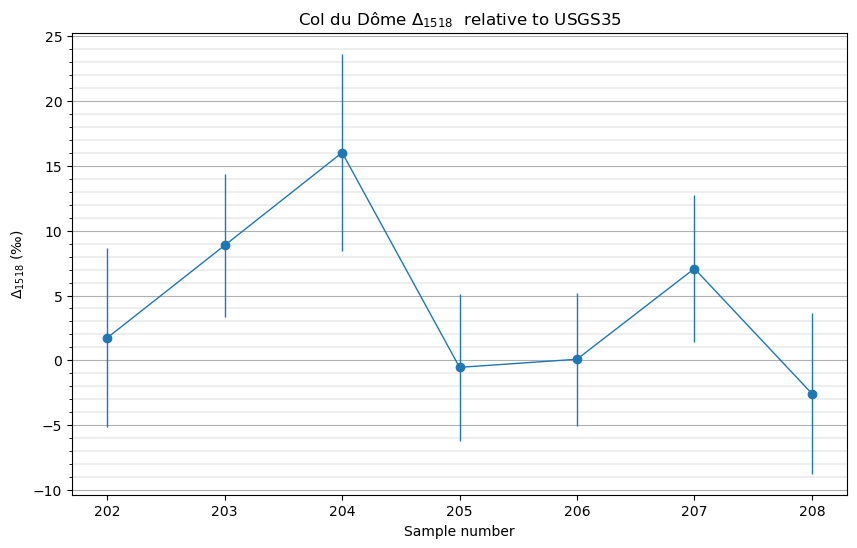

In [257]:
clumps = [ col for col in results_df.columns if col.startswith('D')]
sample_numbers = [ int(name[-3:]) for name in results_df.index ]

fig,ax = plt.subplots(1,len(clumps), figsize=[10,6])

# Plot isotopologues
for i,isotope in enumerate(clumps):
    # plot data with errorbars
    ax.errorbar(sample_numbers,results_df[isotope]*1e3, yerr = results_df['err_'+isotope]*1e3, lw=1,marker='o')
    # plot parameters
    ax.set_ylabel('$\Delta_{'+isotope[1:3]+isotope[4:6]+'}$ (‰)')
    ax.set_xlabel('Sample number')
    ax.set_title('Col du Dôme $\Delta_{'+isotope[1:3]+isotope[4:6]+'}$  relative to USGS35')
    # add y ticks at unit spacing
    ax.set_yticks([i for i in range(int(ax.get_ylim()[0]),int(ax.get_ylim()[1]))], minor=True)
    ax.grid(axis='y')
    ax.grid(axis='y', which='minor',lw=0.3)
